<a href="https://colab.research.google.com/github/ismailkaya83/MY-DEEP-LEARNING-NOTEBOOKS/blob/master/Sequence_processing_with_convnets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In chapter 5, you learned about convolutional neural networks (convnets) and how they perform particularly well on computer vision problems, due to their ability to operate convolutionally, extracting features from local input patches and allowing for representation modularity and data efficiency. The same properties that make convnets excel at computer vision also make them highly relevant to sequence processing. Time can be treated as a spatial dimension, like the height or width of a 2D image.

Such 1D convnets can be competitive with RNNs on certain sequence-processing problems, usually at a considerably cheaper computational cost. Recently, 1D convnets, typically used with dilated kernels, have been used with great success for audio generation and machine translation. In addition to these specific successes, it has long been known that small 1D convnets can offer a fast alternative to RNNs for simple tasks such as text classification and timeseries forecasting.

*Bolum-5'te evrisimli sinir aglarini ve ozellikle bilgisayarli gorude evrisim islemi sayesinde girdideki oruntuleri cikarup gosterimsel gucunu ve etkin calismasini ogrendiniz. Evirisimli sini aglarini bilgisayarli gorude uzman yapan kavramlar sayesinde dizi islemede de kullanilabilir. Zaman bir resmin genisligi ve yuksekligi gibi uzamsal boyut olarak degerlendirilebilir.*

*Boyle 1B evrisimli sinir aglari bazi dizi problemlerinde dusuk hesaplama maliyetleriyle de RNN'lrle yarisabilir. Son zamanlarda 1B evrisimli sinir aglari ozellikle de ayrik filtreleri kullanarak makine cevirisinde ve ses uretmede cok basarili olmuslardir. Bu belirli basarilarin haricinde metin siniflandirma ve zaman serisi tahmininde hizlari dolayisiyla RNN'lere alternatif olmuslardir.*

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Understanding 1D convolution for sequence data**

The convolution layers introduced previously were 2D convolutions, extracting 2D patches from image tensors and applying an identical transformation to every patch. In the same way, you can use 1D convolutions, extracting local 1D patches (subsequences) from sequences

Such 1D convolution layers can recognize local patterns in a sequence. Because the same input transformation is performed on every patch, a pattern learned at a certain position in a sentence can later be recognized at a different position, making 1D convnets translation invariant (for temporal translations). For instance, a 1D convnet processing sequences of characters using convolution windows of size 5 should be able to learn words or word fragments of length 5 or less, and it should be able to recognize these words in any context in an input sequence. A character-level 1D convnet is thus able to learn about word morphology.

*Daha once gordugunuz evrisim katmanlari goruntu tensorlerine 2B evrisim islemiyle ayni donusumu uygulayarak 2B oruntuler cikarir. Ayni sekilde 1B evrisimi dizileri de 1B bolgesel oruntuler (kucuk diziler) ogrenmekte kullanabilirsiniz.*

*Boyle bir evrisim katmani dizilerdeki oruntuleri ogrenebilir. Her bolgeye ayni donusum uygulandigindan bir cumle icinde belli bir yerde ogrenilen oruntu farkli yerlerde tekrar taninabilir ve bu durum 1B evrisimli sinir aglarini yon degismez yapmaktadir. Ornegin, evrisim pencere buyuklugu 5 olan harf bazli bir 1B evrisimli sinir agi, girdi dizisinden 5 veya daha az harf iceren kelimeleri ogrenebilir ve daha sonra bunu herhangi bir girdide taniyabilir. Bu sekilde, harf bazli 1B evrisimli sinir aglari kelime morfolojisini ogrenebilir.*

### **1D pooling for sequence data**

You’re already familiar with 2D pooling operations, such as 2D average pooling and max pooling, used in convnets to spatially downsample image tensors. The 2D pooling operation has a 1D equivalent: extracting 1D patches (subsequences) from an input and outputting the maximum value (max pooling) or average value (average pooling). Just as with 2D convnets, this is used for reducing the length of 1D inputs (subsampling).

*2B en buyukleri biriktirme veya ortalama biriktirme gibi 2B biriktirme islemleri zaten biliyorsunuz. 2B boyutu islemin 1B boyutlu karsiligi da var: 1B parcalardan en buyuk degerini ve ortalama degerini biriktirme. Bu teknik, 2B evrisimli sinir aglarinda oldugu gibi 1B'de de boyut azaltmak icindir.*

### **Implementing a 1D convnet**

In Keras, you use a 1D convnet via the Conv1D layer, which has an interface similar to Conv2D. It takes as input 3D tensors with shape (samples, time, features) and returns similarly shaped 3D tensors. The convolution window is a 1D window on the temporal axis: axis 1 in the input tensor.

Let’s build a simple two-layer 1D convnet and apply it to the IMDB sentiment--classification task you’re already familiar with. As a reminder, this is the code for obtaining and preprocessing the data.

*Keras'ta 1B evrisim islemini Conv1D katmaniyla ayni Con2D katmanini kullandiginiz gibi kullanabilirsiniz. (samples, time, features) seklinde 3B girdi tensorleri alir ve ayni sekilde 3B tensorler dondurur. Evrisim penceresi zaman ekseninde (girdi tensorunun eksen 1'idir) 1B penceredir.*

*Simdi iki katmanli basit bir 1B evrisimli sinir agi insa edelim ve IMDB duygu siniflandirma gorevinde uygulayalim.*

In [2]:
# IMDB veri setini hazirlamak

from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000  # number of words to consider as features
max_len = 500  # cut texts after this number of words (among top max_features most common words)

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Loading data...
17465344/17464789 [==============================] - 0s 0us/step
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 500)
x_test shape: (25000, 500)


1D convnets are structured in the same way as their 2D counterparts, which you used in chapter 5: they consist of a stack of Conv1D and MaxPooling1D layers, ending in either a global pooling layer or a Flatten layer, that turn the 3D outputs into 2D outputs, allowing you to add one or more Dense layers to the model for classification or regression.

One difference, though, is the fact that you can afford to use larger convolution windows with 1D convnets. With a 2D convolution layer, a 3 × 3 convolution window contains 3 × 3 = 9 feature vectors; but with a 1D convolution layer, a convolution window of size 3 contains only 3 feature vectors. You can thus easily afford 1D convolution windows of size 7 or 9.

*1B evrisimli sinir aglari daha once kullandigimiz 2B benzerleriyle ayni yapidadir: Conv1D ve MaxPooling1D katmanlarindan meydana gelmektedir ve en sonda duzlestiren Flatten katmani bulunmaktadir ve 3B ciktilari 2B cikti boyutuna getirerek modelin siniflandirma veya baglanim katmanina yani Dense katmanina gonderir.*

*Ancak aralarinda bir fark vardir, eger 2B evrisim katmaninda 3 × 3 evrisim penceresi kullanirsaniz 9 nitelik vektoru ogrenirken, 1B evrisim katmaninda pencere geisligi 3'e 3 nitelik vektoru ogrenir. Dolayisiyla, 1B evrisim katmaninda 7 ya da 9 gibi daha buyuk pencere buyuklukleri kullanabilirsiniz*

In [6]:
# Training and evaluating a simple 1D convnet on the IMDB data

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 9, activation='relu'))
model.add(layers.MaxPooling1D(7))
model.add(layers.Conv1D(32, 9, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 128)          1280000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 492, 32)           36896     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 70, 32)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 62, 32)            9248      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,326,177
Trainable params: 1,326,177
Non-trainable params: 0
____________________________________________

Here are our training and validation results: validation accuracy is somewhat lower than that of the LSTM we used two sections ago, but runtime is faster, both on CPU and GPU (albeit the exact speedup will vary greatly depending on your exact configuration). At that point, we could re-train this model for the right number of epochs (8), and run it on the test set. This is a convincing demonstration that a 1D convnet can offer a fast, cheap alternative to a recurrent network on a word-level sentiment classification task.

*Dogrulama basarimi LSTM'den biraz daha dusuk olsa da hem CPU hem de GPU calisma suresi daha hizlidir. Bu ornek kelime seviyesi duygu analizinde 1B evrisimli sinir aglarinin yinelemeli aglarin ucuz ve hizli alternatifi oldugunu gosteriyor.*

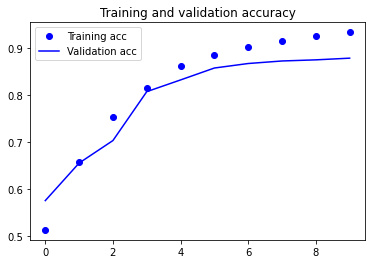

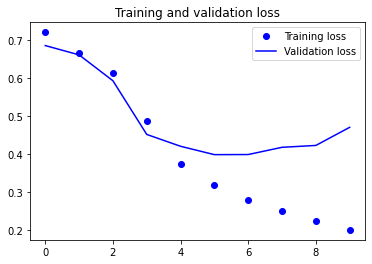

In [7]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### **Combining CNNs and RNNs to process long sequences**

Because 1D convnets process input patches independently, they aren’t sensitive to the order of the timesteps (beyond a local scale, the size of the convolution windows), unlike RNNs. Of course, to recognize longer-term patterns, you can stack many convolution layers and pooling layers, resulting in upper layers that will see long chunks of the original inputs—but that’s still a fairly weak way to induce order sensitivity. One way to evidence this weakness is to try 1D convnets on the temperature-forecasting problem, where order-sensitivity is key to producing good predictions. The following example reuses the following variables defined previously: float_data, train_gen, val_gen, and val_steps.

*1B evrisimli sinir aglari parcalari bagimsiz olarak islediginden RNN'lerden farkli olarak zamansal siralamaya duyarli degiller. Elbette uzun zamanli oruntuleri ogrenmek icin evrisim ve biriktirme katmanlarindan ust uste koyarak ust katmanlarin ozgun girdilerden cok uzun parcalar gormesini saglayabilirsiniz, ama bu siralama hassasiyeti saglama konusunda yine basarisiz olacaktir. Bunun bir kaniti olarak 1B evrisimli sinir aglarini zamansal siralamanin onemli oldugu hava sicakligi tahmin probleminde deneyin. Asagidaki ornek daha once tanimlanan float_ata, train_gen, val_gen ve val_steps degiskenleri aynen kullanmaktadir.*

In [8]:
# veri setini inceleyelim
data_dir = '/content/drive/MyDrive/Colab_Notebooks/Deep_learning_for_text/jena_climate_2009_2016.csv'

f = open(data_dir)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [9]:
"Convert all 420511 lines  of data into a Numpy Array"

import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [10]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [11]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [12]:
lookback = 1440
step = 6
delay = 144
batch_size = 128
train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size # dogrulama veri seti kac adimda gecilecek

test_steps = (len(float_data) - 300001 - lookback) // batch_size # tum test seti kac adimda gorulecek

In [13]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu', input_shape=(None, float_data.shape[-1])))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 32)               

In [14]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
500/500 [==============================] - 11s 23ms/step - loss: 0.4154 - val_loss: 0.4346
Epoch 2/20
500/500 [==============================] - 11s 22ms/step - loss: 0.3582 - val_loss: 0.4295
Epoch 3/20
500/500 [==============================] - 11s 22ms/step - loss: 0.3359 - val_loss: 0.4336
Epoch 4/20
500/500 [==============================] - 11s 22ms/step - loss: 0.3180 - val_loss: 0.4672
Epoch 5/20
500/500 [==============================] - 11s 22ms/step - loss: 0.3060 - val_loss: 0.4601
Epoch 6/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2944 - val_loss: 0.4475
Epoch 7/20
500/500 [==============================] - 11s 23ms/step - loss: 0.2848 - val_loss: 0.4451
Epoch 8/20
500/500 [==============================] - 11s 23ms/step - loss: 0.2804 - val_loss: 0.4433
Epoch 9/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2746 - val_loss: 0.4456
Epoch 

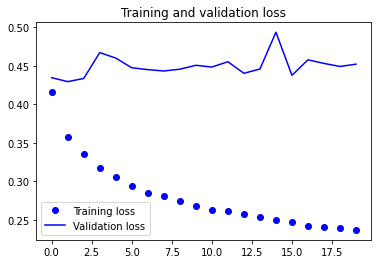

In [18]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

The validation MAE stays in the 0.40s: you can’t even beat the common-sense baseline using the small convnet. Again, this is because the convnet looks for patterns anywhere in the input timeseries and has no knowledge of the temporal position of a pattern it sees (toward the beginning, toward the end, and so on). Because more recent data points should be interpreted differently from older data points in the case of this specific forecasting problem, the convnet fails at producing meaningful results. This limitation of convnets isn’t an issue with the IMDB data, because patterns of keywords associated with a positive or negative sentiment are informative independently of where they’re found in the input sentences.

One strategy to combine the speed and lightness of convnets with the order--sensitivity of RNNs is to use a 1D convnet as a preprocessing step before an RNN (see figure 6.30). This is especially beneficial when you’re dealing with sequences that are so long they can’t realistically be processed with RNNs, such as sequences with thousands of steps. The convnet will turn the long input sequence into much shorter (downsampled) sequences of higher-level features. This sequence of extracted features then becomes the input to the RNN part of the network.

This technique isn’t seen often in research papers and practical applications, possibly because it isn’t well known. It’s effective and ought to be more common. Let’s try it on the temperature-forecasting dataset. Because this strategy allows you to manipulate much longer sequences, you can either look at data from longer ago (by increasing the lookback parameter of the data generator) or look at high-resolution timeseries (by decreasing the step parameter of the generator). Here, somewhat arbitrarily, you’ll use a step that’s half as large, resulting in a timeseries twice as long, where the temperature data is sampled at a rate of 1 point per 30 minutes. The example reuses the generator function defined earlier.

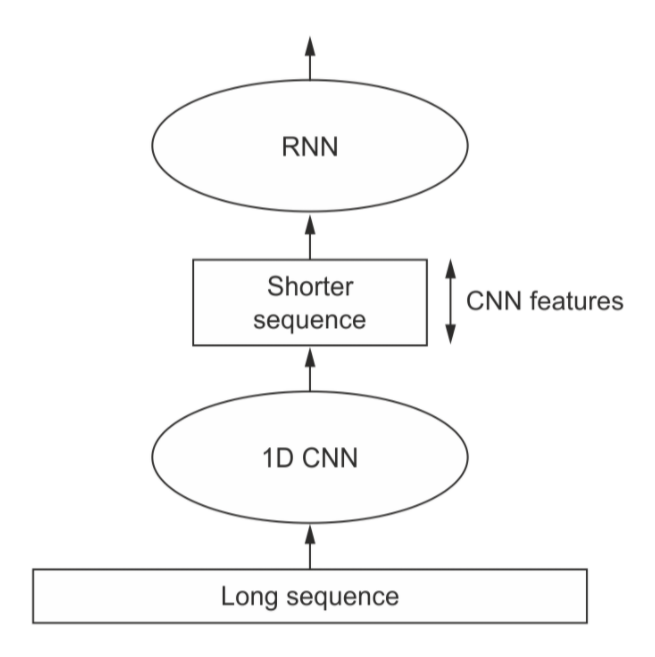

*Dogrulama MAE skoru 0.4 civarinda: Akil yurutme ile elde edilen baz modelden bile daha kotu. Cunku evrisimli sinir aglari zaman serisindeki oruntulere bakarken zamansal pozisyonunu (basinda, sonunda vb.) ogrenmez. Yakin gecmisin uzak gecmisten daha onemli olmasi gereken hava sicakligi tahmin probleminde, evrisimli sinir aglari anlamli sonuclar uretmede basarisiz olmaktadir. Bu sinirlama IMDB veri setinde soz konusu degildir, cunku pozitif veya negatif duygularla iliskili anahtar kelime oruntulerinin cumlenin icindeki yeri onemsizdir.*

*Evrisimli sinir aglarinin hizi ve yetenekleriyle RNN'lerin siralama hassasligini birestirme stratejsisi 1B evrisimli sinir aglarini RNN'den once onislem adimi olarak kullanmaktadir. Bunun normalde islemesi gercekci olmayan cok uzun dizilerde kullanilmasi ozellikle faydali olur. Evrisimli sinir agi uzun diziyi daha kisa (boyutu azaltilmis) ve daha yuksek seviyeli niteliklere dondurecek. Daha sonra bu cikartilmis nitelikler RNN aginin parcasi olacak*

*Bu teknige genelde arastirmalarda veya pratik uygulamalarda cok rastlanmaz. Cunku cok iyi bilinmiyor. Simdi hava sicakligi tahmin veri setinde bunu deneyelim. Bu teknik, cok daha uzun dizileri islemenie imkan sagladigindan daha uzun gecmisten (uretecin lookback parametresini arttirarak) verilere de bakabilirsiniz ya da daha yuksek cozunurlukte zaman serilerine bakabilirsiniz (uretecin step parametresini azaltip). Biz rastgele step parametresini yariya indirip her 30 dakikada 1 ornek olarak sonucta elde edilecek olan zaman serisini iki kat uzatiyoruz.*

In [19]:
step = 3 # dha once 6 olarak secilmisti, (saatte 1 ornek) simdi 30 dakikada bir ornek
lookback = 720
delay = 144

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step)
val_steps = (300000 - 200001 - lookback) // 128
test_steps = (len(float_data) - 300001 - lookback) // 128

In [20]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32))
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
gru (GRU)                    (None, 32)                6336      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 13,793
Trainable params: 13,793
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
500/500 [==============================] - 12s 25ms/step - loss: 0.3222 - val_loss: 0.2745
Epoch 2/20
500

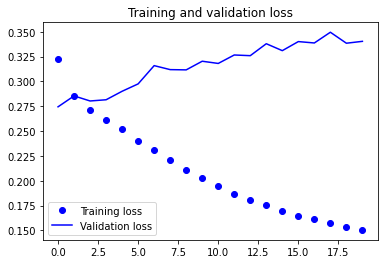

In [21]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Judging from the validation loss, this setup isn’t as good as the regularized GRU alone, but it’s significantly faster. It looks at twice as much data, which in this case doesn’t appear to be hugely helpful but may be important for other datasets.

*Dogrulama kaybina bakinca, bu model duzenlilestirilmis GRU katmanli yapilandirma kadar iyi degil ama gozle gorunur derecede hizli. Iki kati veriye bakiyor, bu veri setinde cok da onemli degil gibi gorunse de baska veri setlerinde elzem olabilir.*

### **Wrapping up**

- In the same way that 2D convnets perform well for processing visual patterns in 2D space, 1D convnets perform well for processing temporal patterns. They offer a faster alternative to RNNs on some problems, in particular natural--language processing tasks.
- Typically, 1D convnets are structured much like their 2D equivalents from the world of computer vision: they consist of stacks of Conv1D layers and Max-Pooling1D layers, ending in a global pooling operation or flattening operation.
- Because RNNs are extremely expensive for processing very long sequences, but 1D convnets are cheap, it can be a good idea to use a 1D convnet as a preprocessing step before an RNN, shortening the sequence and extracting useful representations for the RNN to process.

- *2B evrisimli sinir aglari gorsel oruntulerde iyi oldugu gibi 1B evrisimli sinir aglari zamansal oruntulerde iyi performans gosterirler. Bazi problemlerde RNN'lere hizli bir alternatif olabilirler, ozellikle de dogal dil isleme problemlerinde.*
- *1B evrisimli sinir aglari bilgisayarli gorudeki 2B evrisimli sinir aglarinin karsiligidir. Conv1D ve MaxPooling1D katmanlarinin ust uste gelmesiyle olusturulur ve en sona global biriktirme veya duzlestiren katmanlar eklenir.*
- *RNN'leri cok uzun dizilerde calistirmak yuksek maliyetli oldugundan, 1B evrisimli sinir aglari dusuk maliyetli olmasi nedeniyle RNN'den once dizileri kisaltan bir onislem olarak kullanilmaktadir.*